# scVelo - 03_2D_withoutD3

Suppl. Fig. 9

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore", UserWarning)

import glob
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt

# from scipy import sparse
# from natsort import natsorted
from matplotlib import rcParams

sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 3

scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.settings.set_figure_params('scvelo')

In [2]:
%run ../scripts/helpers.py

In [3]:
adata = sc.read("../data/processed/01_raw_counts.h5ad")
metadata = pd.read_csv("../data/processed/03_2D_withoutD3.metadata.csv", index_col=0)

adata = adata[metadata.index]
adata.obs = metadata

adata.obsm['X_umap'] = pd.read_csv("../data/processed/03_2D_withoutD3.umap.csv", index_col=0).to_numpy()

# fix spaces in metadata
adata.obs.Cell_barcode = adata.obs.Cell_barcode.str.strip().astype('category')
adata.obs.Pool_barcode = adata.obs.Pool_barcode.str.strip()
adata.obs['barcodes'] = adata.obs['Pool_barcode'].str.strip() + adata.obs['Cell_barcode'].str.strip()

adata.obs.cluster_names = adata.obs.cluster_names.astype('category')

... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Protocol' as categorical
... storing 'barcodes' as categorical


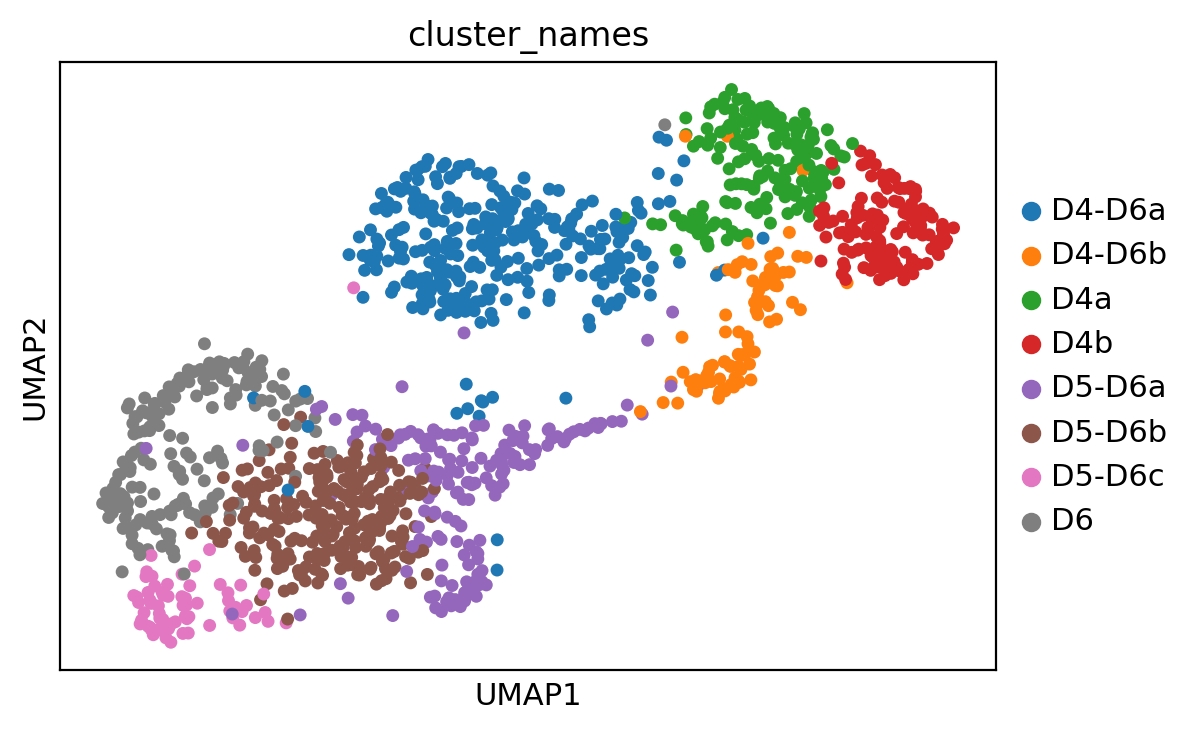

In [4]:
sc.pl.umap(adata, color='cluster_names')

In [5]:
velocity_batches = []
for batch in adata.obs.Batch.unique():
    print(f"Processing {batch}")
    velocity_batch = buildAnndataFromStar(f"../data/raw/velocity/{batch}/Solo.out/")
    obs = adata[adata.obs.Batch == batch].obs.reset_index().set_index('barcodes')
    common_cells = np.intersect1d(obs.index, velocity_batch.obs_names)
    
    velocity_batch = velocity_batch[common_cells].copy()
    velocity_batch.obs = obs.loc[common_cells]
    velocity_batch.obs = velocity_batch.obs.set_index("Well_ID")

    velocity_batches.append(velocity_batch)

Processing SB1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing SB2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing SB3


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing SB7


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing SB8


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing SB10


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
merged = anndata.concat(velocity_batches)

In [7]:
adata_velocity = scv.utils.merge(adata, merged)

In [8]:
adata_velocity

AnnData object with n_obs × n_vars = 1388 × 33924
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nUMI', 'nGene', 'Well_ID', 'Well_coordinates', 'plate_ID', 'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'SubGroup', 'Day', 'Amp_batch_ID.1', 'Well_ID.1', 'Protocol', 'FACS_index', 'percent.mito', 'percent.ercc', 'RNA_snn_res.0.8', 'seurat_clusters', 'cluster_names', 'barcodes', 'index', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    uns: 'cluster_names_colors'
    obsm: 'X_umap'
    layers: 'spliced', 'unspliced', 'ambiguous'

In [9]:
adata_velocity.write("../data/processed/03_2D_withoutD3.h5ad")

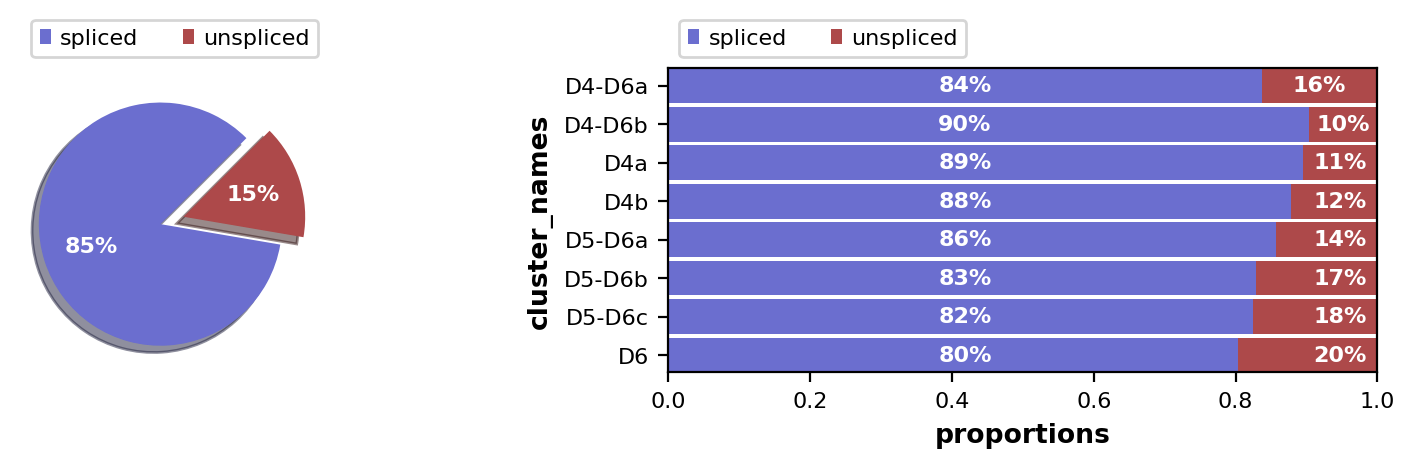

In [10]:
scv.pl.proportions(adata_velocity, groupby='cluster_names')

In [11]:
adata_velocity = run_scvelo(adata_velocity)

Filtered out 29551 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30


Extracted 2000 highly variable genes.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/12 cores)


  0%|          | 0/635 [00:00<?, ?gene/s]

    finished (0:00:29) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


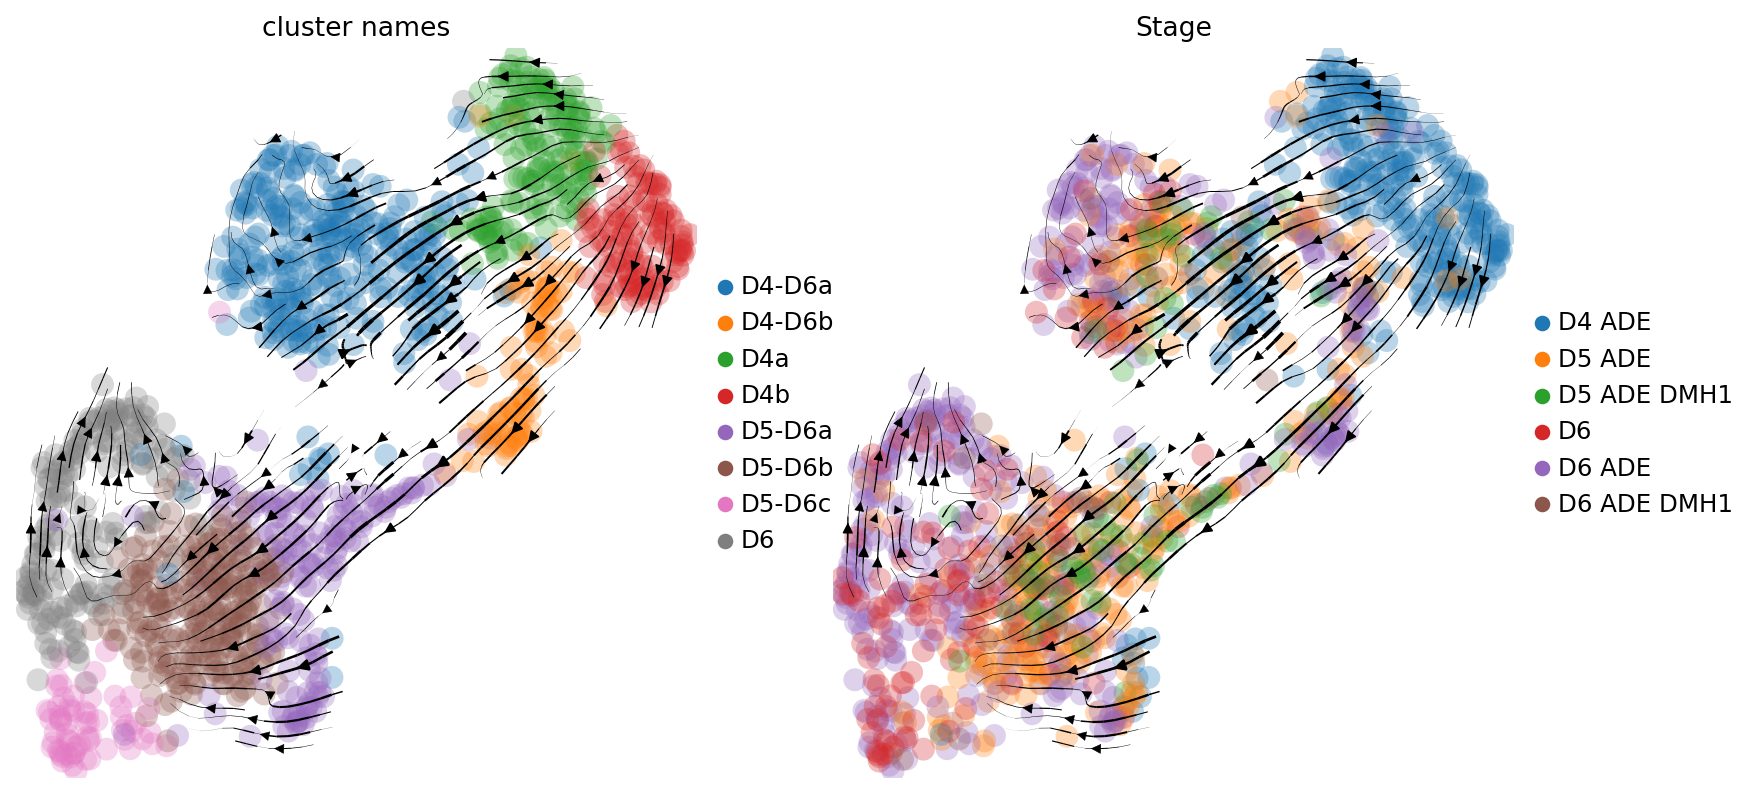

In [12]:
rcParams['figure.figsize'] = [12, 12]
scv.pl.velocity_embedding_stream(adata_velocity, basis='umap', color=['cluster_names', 'Stage'], legend_loc = 'right')

saving figure to file ./figures/scvelo_2D_velo.svg


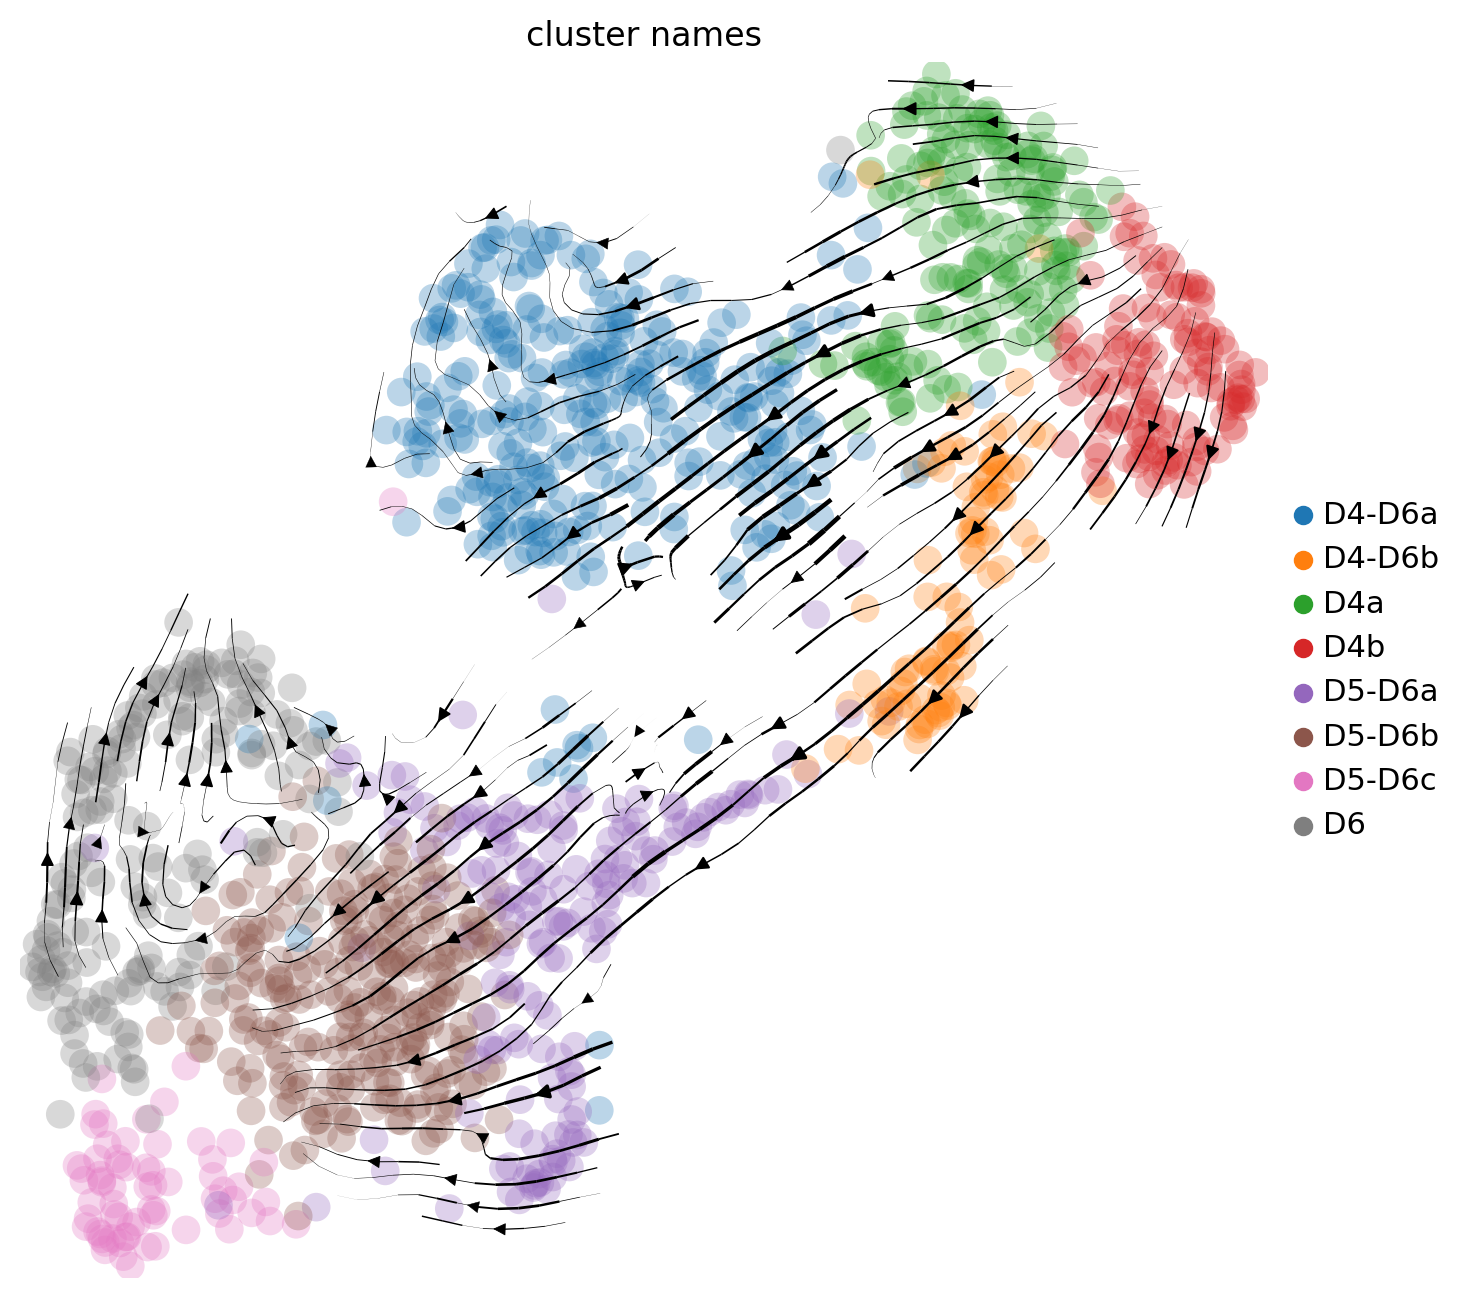

In [13]:
rcParams['figure.figsize'] = [8, 8]
scv.pl.velocity_embedding_stream(adata_velocity, basis='umap', color='cluster_names', alpha=0.3, legend_loc = 'right')

saving figure to file ./figures/scvelo_2D_velo.svg


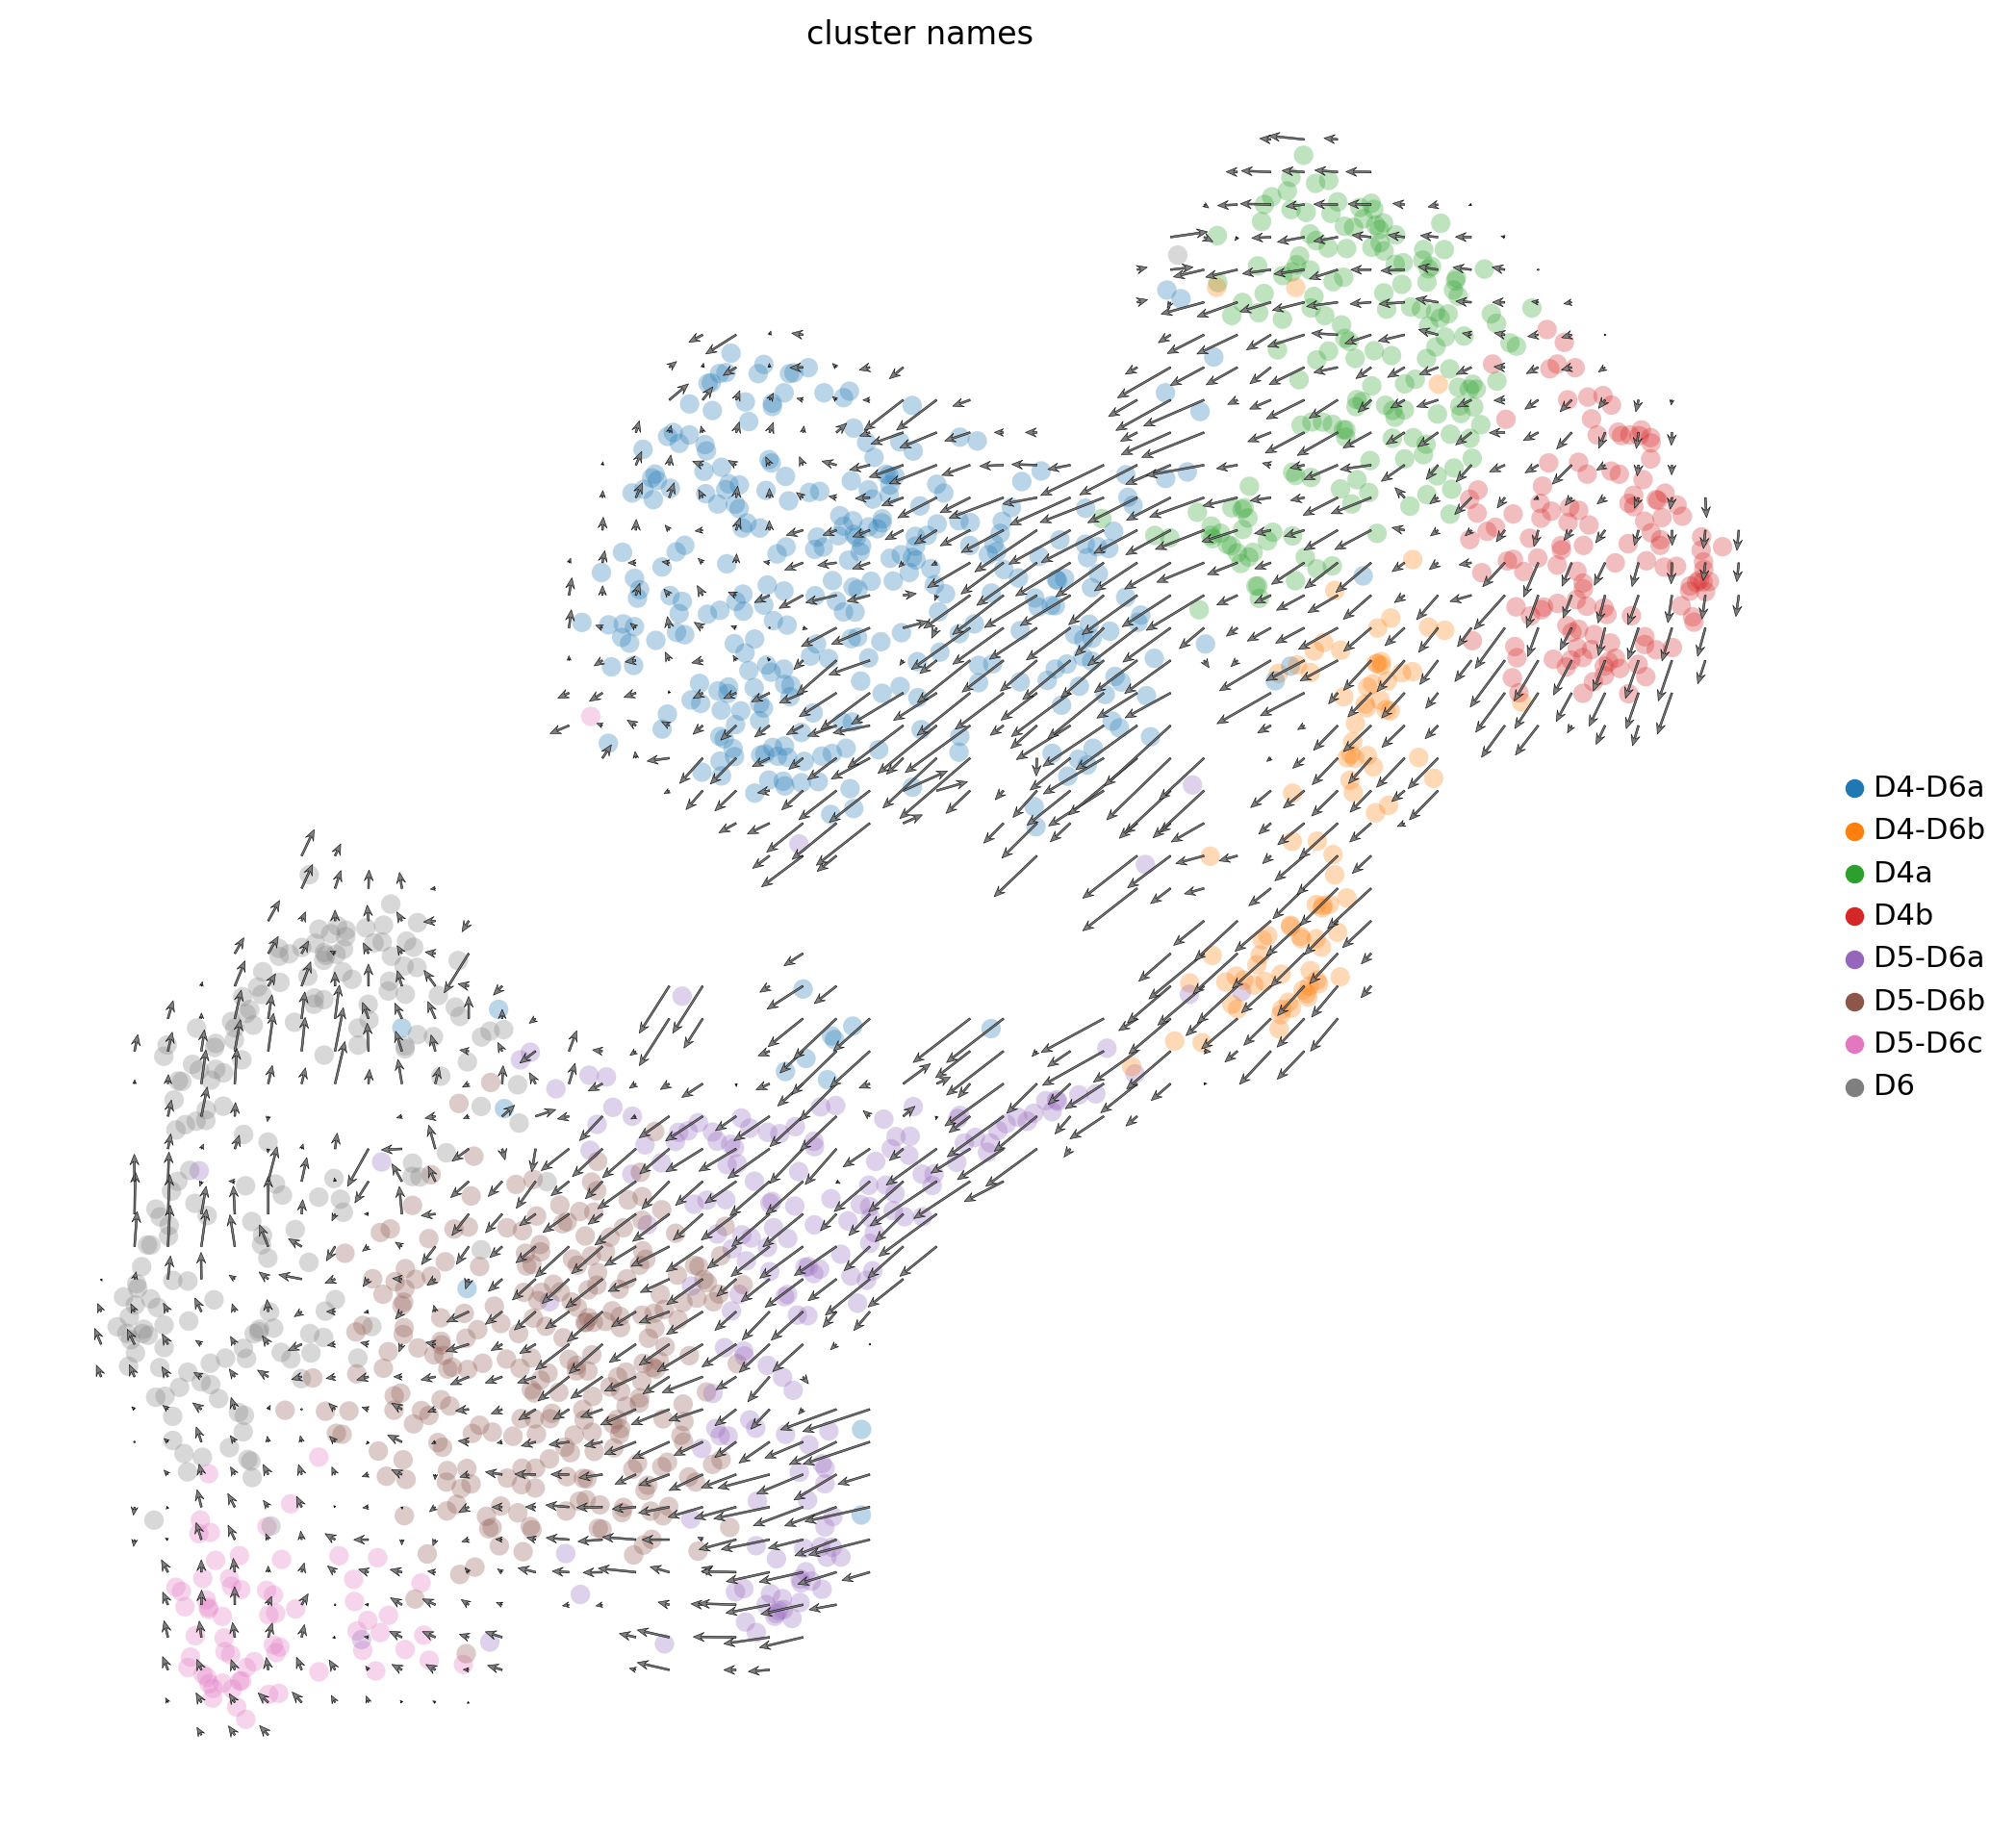

In [14]:
rcParams['figure.figsize'] = [15, 15]
scv.pl.velocity_embedding_grid(adata_velocity, basis='umap', color='cluster_names', arrow_length=5, alpha=0.3, legend_loc = 'right')

In [15]:
adata_velocity.uns['neighbors']['distances'] = adata_velocity.obsp['distances']
adata_velocity.uns['neighbors']['connectivities'] = adata_velocity.obsp['connectivities']

scv.tl.paga(adata_velocity, groups='cluster_names')
df = scv.get_df(adata_velocity, 'paga/transitions_confidence', precision=2, index=adata_velocity.obs.seurat_clusters.cat.categories, columns=adata_velocity.obs.seurat_clusters.cat.categories).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


saving figure to file ./figures/scvelo_paga_vitro.svg


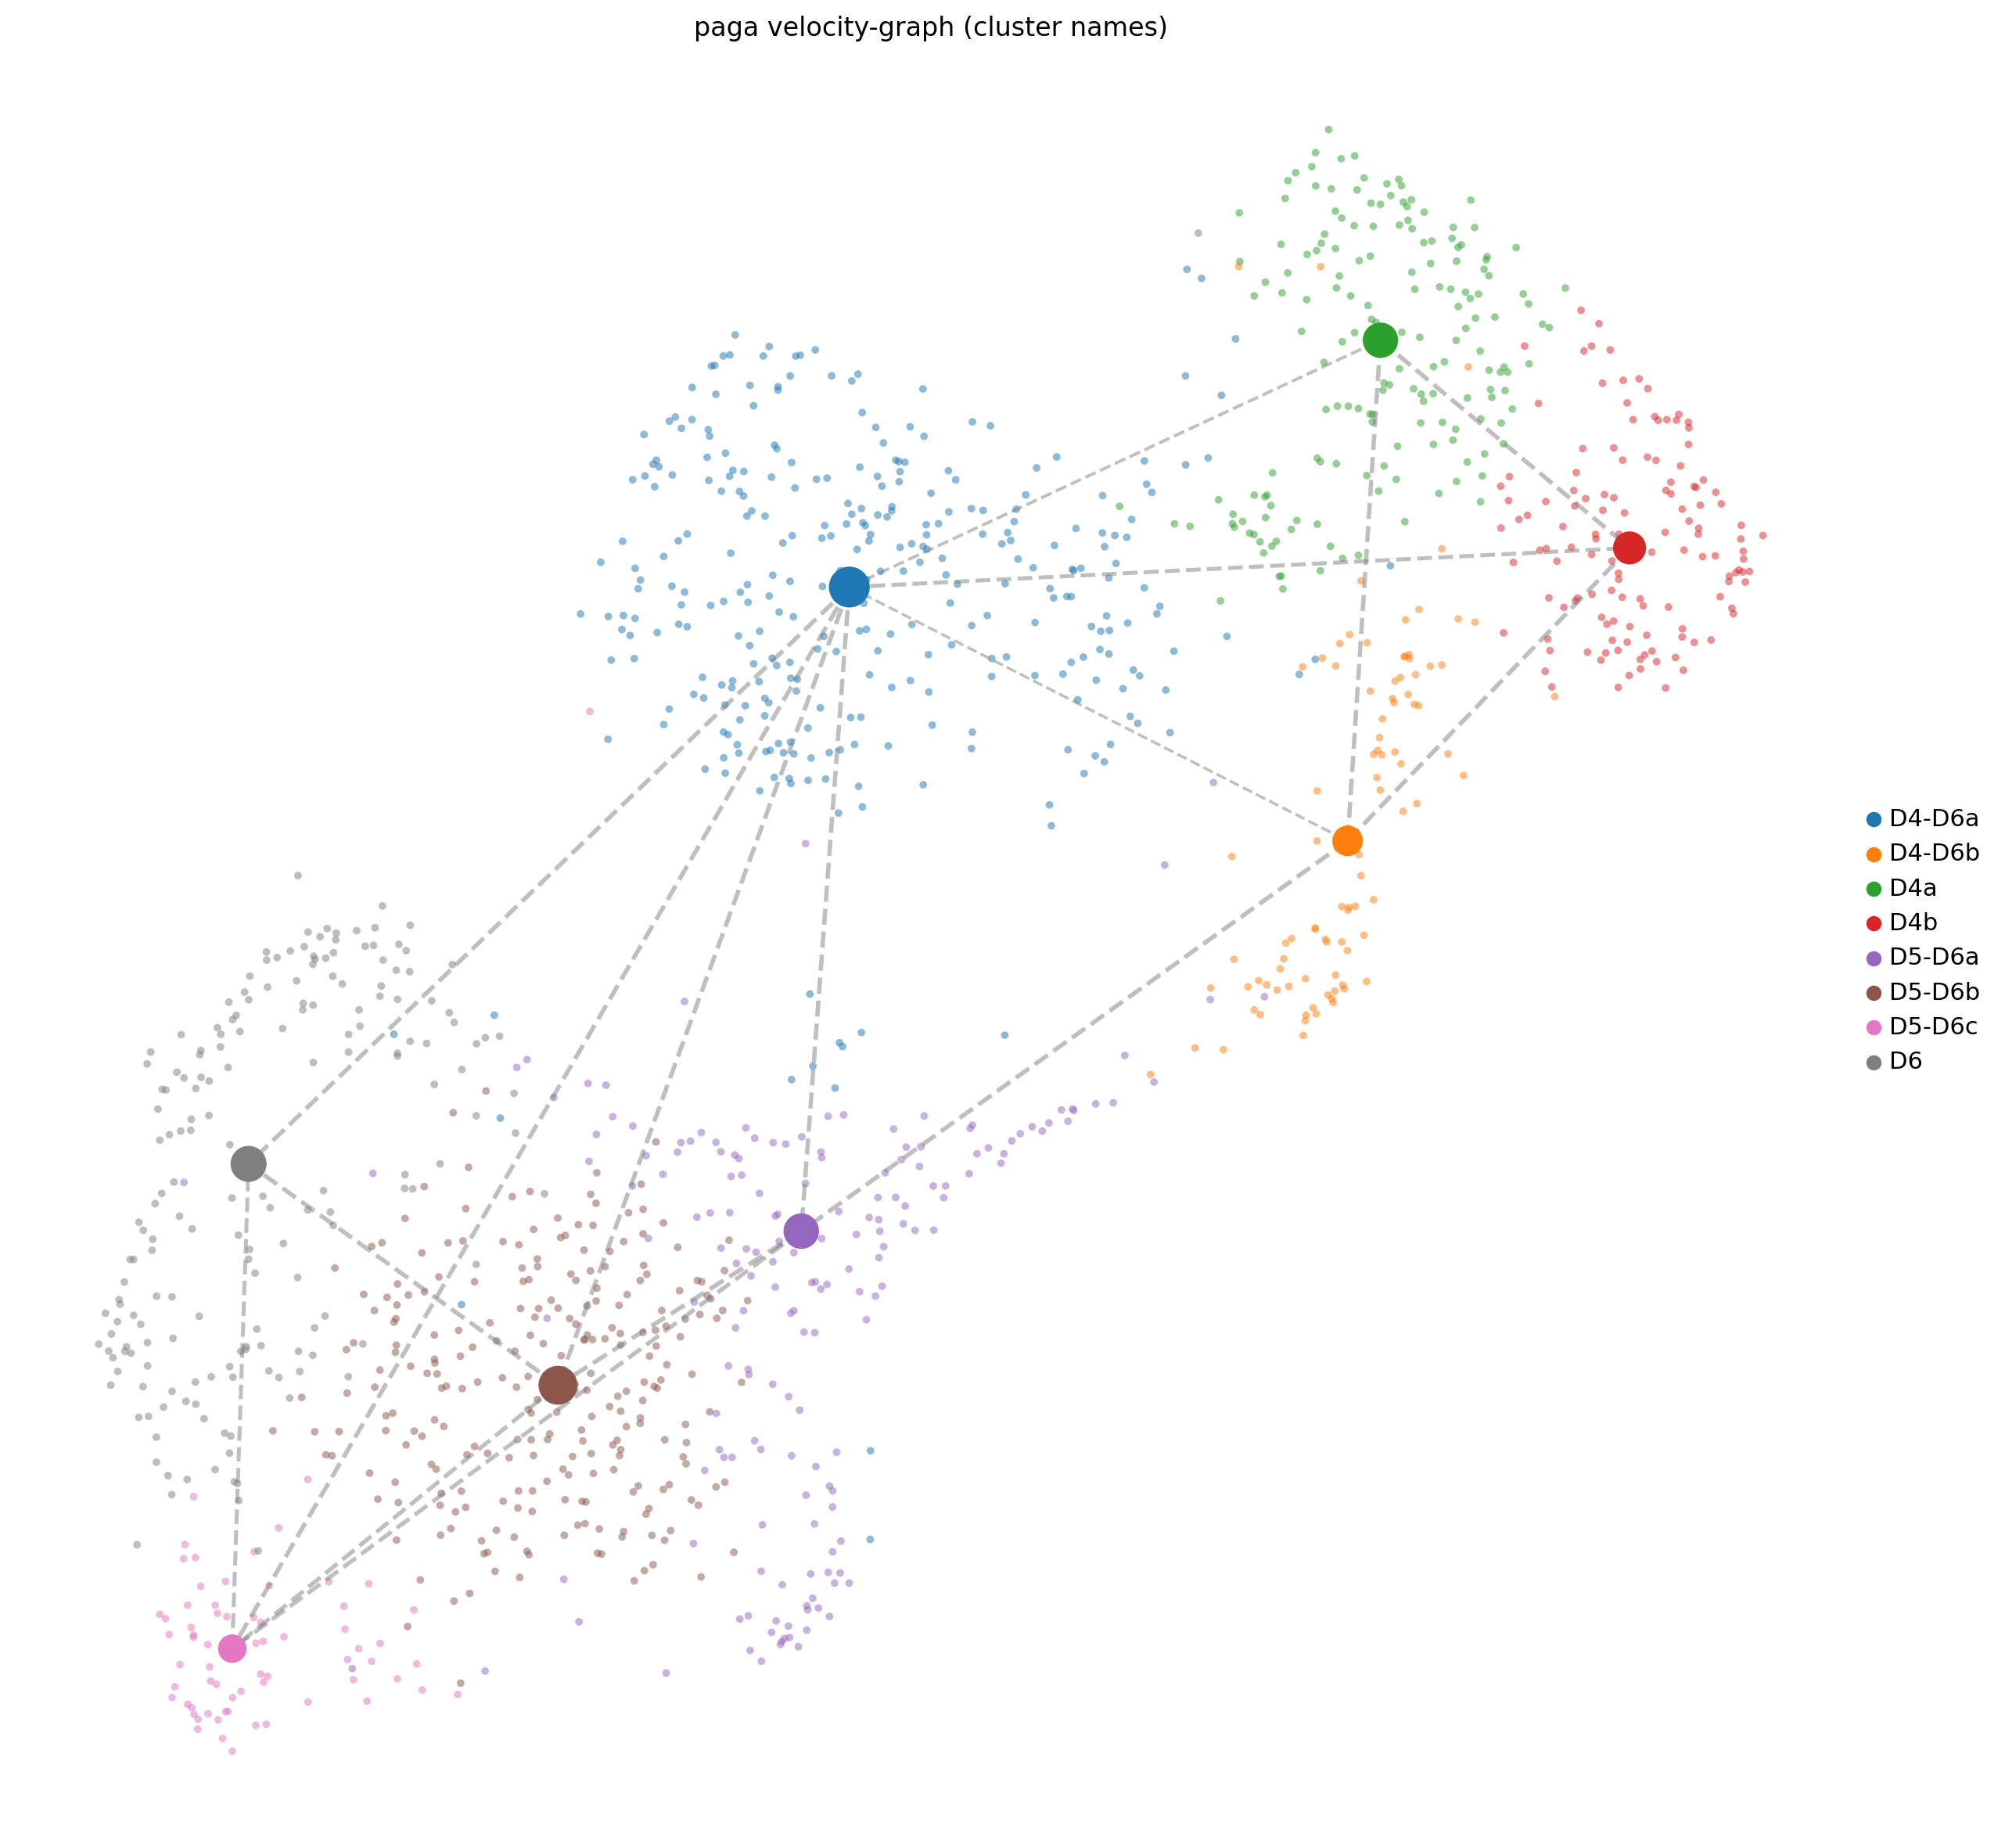

In [16]:
rcParams['figure.figsize'] = [15, 15]
scv.pl.paga(adata_velocity, basis='umap', size=50, alpha=.5, min_edge_width=2, node_size_scale=1.5, threshold=0.4)

In [1]:
!jupyter nbconvert --to html 03_2D_withoutD3.ipynb --output-dir="../reports"

[NbConvertApp] Converting notebook 03_2D_withoutD3.ipynb to html
[NbConvertApp] Writing 4967934 bytes to ../reports/03_2D_withoutD3.html
